## Rating the Complexity of Text Passages - EDA

This notebook is made separately from the main notebook as we want to focus on visualizing the data we have in our dataset, and finding hidden patterns for our analysis.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import textstat
import rich
import spacy
import scipy
from rich.console import Console
from rich.theme import Theme
from nltk.corpus import stopwords
from nltk import pos_tag
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haider\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Loading English pipeline 
from spacy.cli import download
print(download('en_core_web_sm'))
nlps = spacy.load('en_core_web_sm')
#Download stopwords from NLTK
nltk.download('stopwords')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
None


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haider\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
train_df = pd.read_csv("C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/train_read.csv")
test_df = pd.read_csv("C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/test_read.csv")

df = pd.concat([train_df, test_df], axis=0)
df.reset_index(drop=True, inplace=True)

In [4]:
df.head()

,excerpt,id,license,standard_error,target,url_legal
0,When the young people returned to the ballroom...,c12129c31,NaN,0.464009,-0.340259,NaN
1,"All through dinner time, Mrs. Fayre was somewh...",85aa80a4c,NaN,0.480805,-0.315372,NaN
2,"As Roger had predicted, the snow departed as q...",b69ac6792,NaN,0.476676,-0.580118,NaN
3,And outside before the palace a great garden w...,dd1000b26,NaN,0.450007,-1.054013,NaN
4,Once upon a time there were Three Bears who li...,37c1b32fb,NaN,0.510845,0.247197,NaN


### Data Preprocessing
This is an important step before we can proceed to our analysis. This is some of the steps that will be used to process the text data:

- Filtering important columns from dataset
- Removing any unnecessary characters
- Lowercasing all texts
- Word tokenization
- Removing stopwords
- Word Lemmatization

In [5]:
#Select columns from dataset
eda_df = df[['id', 'excerpt','target', 'standard_error']]

In [6]:
#Text cleaning (with tokenization and lemmatization)
def text_cleaning(data):
    excerpt_new=[]
    for text in data['excerpt']:  
        # find alphabets
        text = re.sub("[^a-zA-Z]", " ", text)
        # convert to lower case
        text = text.lower()
        # tokenize words
        text = nltk.word_tokenize(text)
        # remove stopwords
        text = [word for word in text if not word in set(stopwords.words("english"))]
        # lemmatization
        lemma = nltk.WordNetLemmatizer()
        text = [lemma.lemmatize(word) for word in text]
        text=" ".join(text)
        excerpt_new.append(text)  
    return excerpt_new 

eda_df["excerpt_preprocessed"] = text_cleaning(eda_df)

#### Extracting entities
Entities may included some categories like names of persons, locations, expressions of times, organizations, quantities, monetary values and so on. We can retrieved it by using Named Entity Recognition (NER) from spaCy libraries. In here, we want to collect:

- Countries mentioned in the texts (GPE)
- Names of the person mentioned in the texts (PERSON)
- Time events mentioned in the texts (EVENT)

In [7]:
#Extracting entities from the texts
ent_per_text = []

for E in eda_df['excerpt']:
    
    entity_tagged = {'GPE'    : [],
                     'PERSON' : [],
                     'EVENT'  : [],
                    }
    for word in nlps(E).ents:
        if word.label_ in ['GPE','PERSON','EVENT']:
            entity_tagged[word.label_].append(word)
    ent_per_text.append(entity_tagged)   

#Named Entity Extraction column
eda_df['# Of Different Countries Mentioned']  = eda_df['excerpt'].apply(lambda x: len([word for word in nlps(x).ents if word.label_ == 'GPE' ]))
eda_df['# Of Different People Mentioned']     = eda_df['excerpt'].apply(lambda x: len([word for word in nlps(x).ents if word.label_ == 'PERSON' ]))
eda_df['# Of Different Facilities Mentioned'] = eda_df['excerpt'].apply(lambda x: len([word for word in nlps(x).ents if word.label_ == 'FAC' ]))


#### Calculating text properties
- The length of the text
- Average length of the words in the text
- The number of lexicon in the text (words with its related knowledge on their linguistic significance and usage)
- The number of sentences in the text
- The estimated school grade level required to understand the text
   - For example, if the text has a score of 9.4 from Flesch Reading Ease Test , it means that a 9th grader would be able to read the document. 

In [8]:
def avg_word_length(data):
    data = data.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    return data

def lexicon(data): 
    lexi = []
    for text in data:  
        lx = textstat.lexicon_count(text)
        lexi.append(lx)
    return lexi

def sentence(data):
    sent_count = []
    for text in data:  
        sc = textstat.sentence_count(text)
        sent_count.append(sc)
    return sent_count

def flesch_level(data):
    flesch = []
    for text in data:  
        fl = textstat.flesch_kincaid_grade(text)
        flesch.append(fl)
    return flesch

def flesch_score(data):
    flesch_s = []
    for text in data:  
        flc = textstat.flesch_reading_ease(text)
        flesch_s.append(flc)
    return flesch_s

In [9]:
eda_df['text_len'] = eda_df['excerpt'].str.len()                      # text length of original text
eda_df['text_len_pre'] = eda_df['excerpt_preprocessed'].str.len()     # text length for preprocessed text
eda_df['lexicon_count'] = lexicon(eda_df['excerpt'])                  # the number of words present in original text
eda_df['lexicon_count_pre'] = lexicon(eda_df['excerpt_preprocessed']) # the number of words present in preprocessed text
eda_df['avg_word_length'] = avg_word_length(eda_df['excerpt'])               # Average word length for original text
eda_df['avg_word_length_pre'] = avg_word_length(eda_df['excerpt_preprocessed'])  # Average word length for preprocessed text
eda_df['sentence_count'] = sentence(eda_df['excerpt'])                # The number of sentences in the texts
eda_df['flesch_score'] = flesch_score(eda_df['excerpt'])              #Flesch reading ease score for each text
eda_df['flesch_level'] = flesch_level(eda_df['excerpt'])              # The Fleasch reading level for each text row

In [10]:
eda_df.head()

,id,excerpt,target,standard_error,excerpt_preprocessed,# Of Different Countries Mentioned,# Of Different People Mentioned,# Of Different Facilities Mentioned,text_len,text_len_pre,lexicon_count,lexicon_count_pre,avg_word_length,avg_word_length_pre,sentence_count,flesch_score,flesch_level
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,young people returned ballroom presented decid...,0,0,0,992,591,179,91,4.547486,5.505495,11,80.31,6.1
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time mr fayre somewhat silent eye resti...,0,2,0,937,551,169,85,4.550296,5.494118,12,82.54,5.2
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,roger predicted snow departed quickly came two...,0,12,0,908,527,166,84,4.475904,5.285714,8,75.74,7.9
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,outside palace great garden walled round fille...,1,0,0,909,573,164,94,4.548780,5.106383,5,72.02,11.4
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,upon time three bear lived together house wood...,0,4,0,723,413,147,74,3.925170,4.594595,5,75.47,10.0


In [11]:
eda_df.loc[8]

id                                                                             f7eff7419
excerpt                                The boys left the capitol and made their way d...
target                                                                         -0.371641
standard_error                                                                   0.46371
excerpt_preprocessed                   boy left capitol made way long hill main busin...
# Of Different Countries Mentioned                                                     0
# Of Different People Mentioned                                                        7
# Of Different Facilities Mentioned                                                    0
text_len                                                                             903
text_len_pre                                                                         579
lexicon_count                                                                        163
lexicon_count_pre    

In [12]:
# Save our dataframe in new csv file for review purposes.
eda_df.to_csv("C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/eda_df.csv", index=False)

### Exploratory data Analysis

#### 1) Distribution and correlation of target and standard error

- Target column is named as **target** and it is reading ease of the excerpt. 
- Every excerpt with target value greater than 0 are easier to read and every excerpt with target value less than 0 are harder to read compared to that particular excerpt. 
- As there were multiple raters, **standard_error** tells us the measure of spread of scores among the raters for each excerpt.

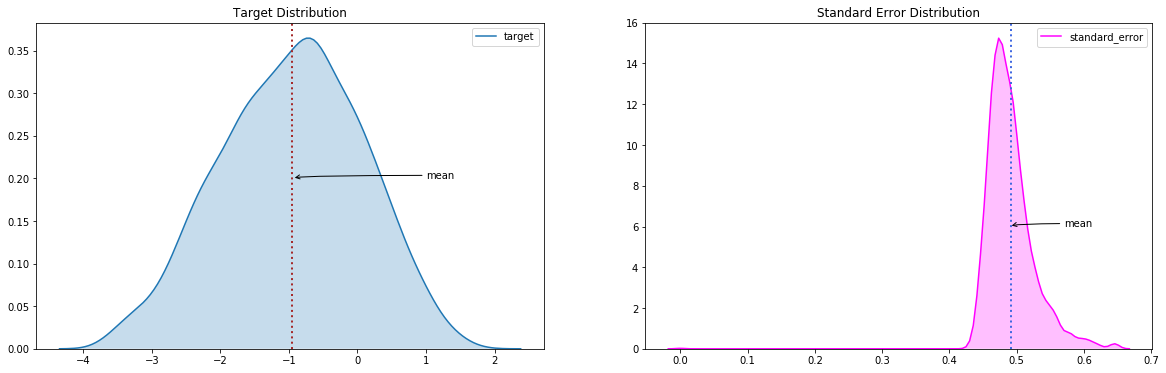

In [13]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
sns.kdeplot(eda_df['target'], shade=True,ax=ax[0])
sns.kdeplot(eda_df['standard_error'], color="fuchsia", shade=True,ax=ax[1])
ax[0].axvline(eda_df['target'].mean(), color="brown",linestyle=':', linewidth=2)
ax[1].axvline(eda_df['standard_error'].mean(), color="royalblue",linestyle=':', linewidth=2)
ax[0].set_title("Target Distribution")
ax[1].set_title("Standard Error Distribution")
ax[0].annotate('mean', xy=(-0.3* np.pi, 0.2), xytext=(1, 0.2), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));
ax[1].annotate('mean', xy=(0.49, 6), xytext=(0.57, 6),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));
plt.savefig('C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/Target-Standard Error Distribution.jpeg',
            dpi = 600)
plt.show()

In [14]:
print("Average target = ",eda_df['target'].mean())
print("Target max: ", eda_df['target'].max())
print("Target min: ", eda_df['target'].min())
print("Target (Local Maximum Value) = ", scipy.stats.mode(eda_df.target)[0])
print()
print("Average standard error = ",eda_df['standard_error'].mean())
print("Standard_error max: ", eda_df['standard_error'].max())
print("Standard_error min: ", eda_df['standard_error'].min())

Average target =  -0.9593187699947089
Target max:  1.7113898269999999
Target min:  -3.676267773
Target (Local Maximum Value) =  [-3.67626777]

Average standard error =  0.4914350909897673
Standard_error max:  0.649671297
Standard_error min:  0.0


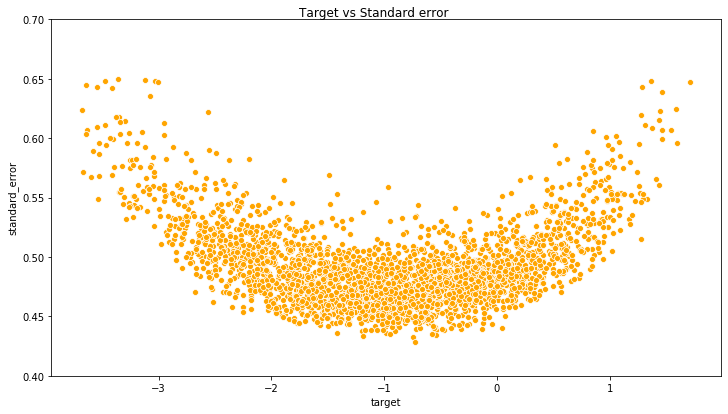

In [15]:
#Correlation of target and standard error
plt.figure(figsize=(12,6))
sns.scatterplot( x=eda_df['target'],  y=eda_df['standard_error'], color = 'orange')
plt.suptitle("Target vs Standard error ")
plt.subplots_adjust(top=0.95)
plt.ylim(ymin=0.4, ymax = 0.7)
plt.savefig('C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/Target vs Standard Error(2).jpeg',
            dpi = 600)
plt.show()

<Figure size 864x432 with 0 Axes>

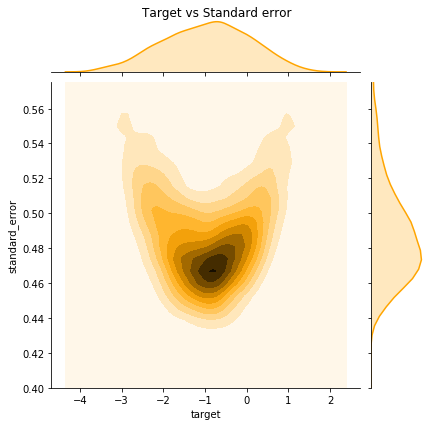

In [16]:
plt.figure(figsize=(12,6))
sns.jointplot( x=eda_df['target'],  y=eda_df['standard_error'], color = 'orange', kind = "kde")
plt.suptitle("Target vs Standard error ")
plt.subplots_adjust(top=0.95)
plt.ylim(ymin=0.4, ymax = 0.575)
plt.savefig('C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/Target vs Standard Error(1).jpeg',
            dpi = 600)
plt.show()

- When standard_error is plotted against target, a relationship can be seen. 
- Excerpts with medium ease of read tend to have less spread of scores, however excerpts at both ends have more spread because they are either too easy or too hard for the raters. 

#### 2) Relationship between target and flesch score 

We want to see either the target and the flesch score have a certain relationship in between. 

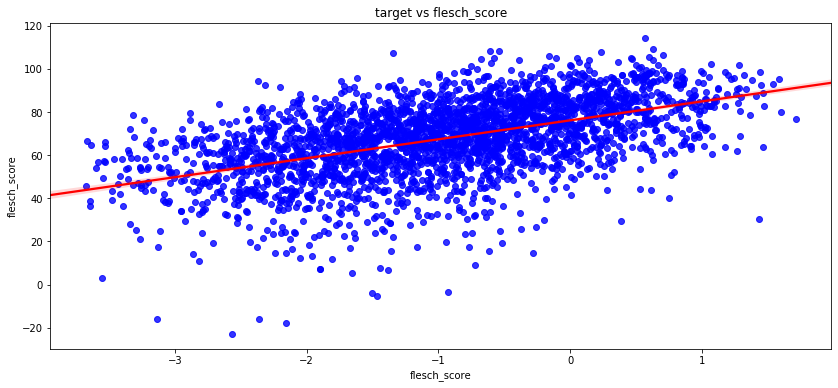

In [17]:
plt.figure(figsize=(14,6))
plt.title('target vs flesch_score')
sns.regplot(eda_df['target'],
            eda_df['flesch_score'],
            scatter_kws={"color": "blue"},
            line_kws={"color": "red"})
plt.xlabel('flesch_score')
plt.savefig('C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/target vs fl_score.jpeg',
            dpi = 600)
plt.show()

It is found that target is very highly correlated with the flesch_score. As the target value increases, the flesch_score also increases, indicate that the excerpt is easier to read as the target value increase.

#### 2) Distribution of Flesch Reading Ease Score and Flesch Reading Grade Level

<img src="https://th.bing.com/th/id/R54c7abd98d2f554bfffd84a8d21d91d9?rik=OH75NDNquiiosg&riu=http%3a%2f%2fheidicohen.com%2fwp-content%2fuploads%2fFlesch-Kincaid-Reading-Ease-Chart.jpg&ehk=J7W3quhnyhPgBS%2bak9Qv58ApyKQsd%2f2wAyrH6l8aGGY%3d&risl=&pid=ImgRaw" alt="image info" />

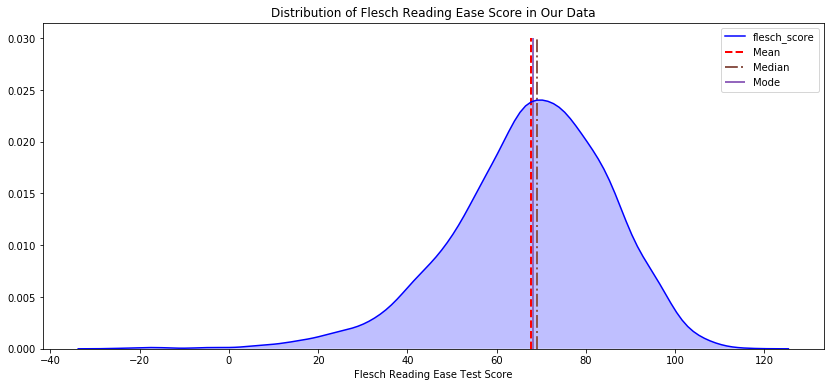

In [18]:
plt.figure(figsize=(14,6))
plt.title('Distribution of Flesch Reading Ease Score in Our Data')
plt.vlines(eda_df.flesch_score.mean(),0,0.03,color='red',label='Mean',lw=2,ls='--')
plt.vlines(eda_df.flesch_score.median(),0,0.03,color='tab:brown',label='Median',lw=2,ls='-.')
plt.vlines(scipy.stats.mode(eda_df.flesch_score)[0],0,0.03,color='tab:Purple',label='Mode',lw=2,ls='-')
sns.kdeplot(eda_df['flesch_score'], shade=True, color = 'blue')
plt.xlabel('Flesch Reading Ease Test Score')
plt.legend()
plt.savefig('C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/Flesch Score Distribution.jpeg',
            dpi = 600)
plt.show()

In [19]:
print("Average Flesch Reading Ease Test Score = ", eda_df.flesch_score.mean())
print("Flesch Reading Ease Test Score (Median) = ", eda_df.flesch_score.median())
print("Flesch Reading Ease Test Score (Local Maximum Value) = ", scipy.stats.mode(eda_df.flesch_score)[0])

Average Flesch Reading Ease Test Score =  67.73681098204858
Flesch Reading Ease Test Score (Median) =  69.01
Flesch Reading Ease Test Score (Local Maximum Value) =  [68.13]


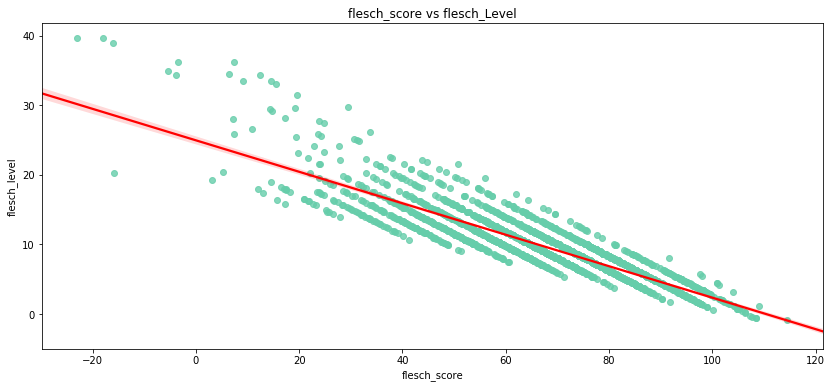

In [20]:
plt.figure(figsize=(14,6))
plt.title('flesch_score vs flesch_Level')
sns.regplot(eda_df['flesch_score'],
            eda_df['flesch_level'],
            scatter_kws={"color": "mediumaquamarine"},
            line_kws={"color": "red"})
plt.xlabel('flesch_score')
plt.savefig('C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/Fl_score vs Fl_level.jpeg',
            dpi = 600)
plt.show()

This regression analysis shows the regrression plot between flesch_score and flesch level. The regression line goes down, indicate that higher the Flesch readability score, the lower the level of reading ease. 

#### 3) Analyzing entities
- Looking at top 10 most entities mentioned for every categories

In [21]:
ALL_GPS    = []
ALL_PERSON = []
ALL_EVENT  = []
for dic in ent_per_text:
    for key in ['GPE','PERSON','EVENT']:
        if len(dic['GPE']) != 0:
            ALL_GPS+=list(dic['GPE'])
        if len(dic['PERSON']) != 0:
            ALL_PERSON+=(dic['PERSON'])
        if len(dic['EVENT']) != 0:
            ALL_EVENT+=(dic['EVENT'])
top_10_places = pd.Series([i.text for i in ALL_GPS]).value_counts()[:10]
top_10_person = pd.Series([i.text for i in ALL_PERSON]).value_counts()[:10]
top_10_event = pd.Series([i.text for i in ALL_EVENT]).value_counts()[:10]

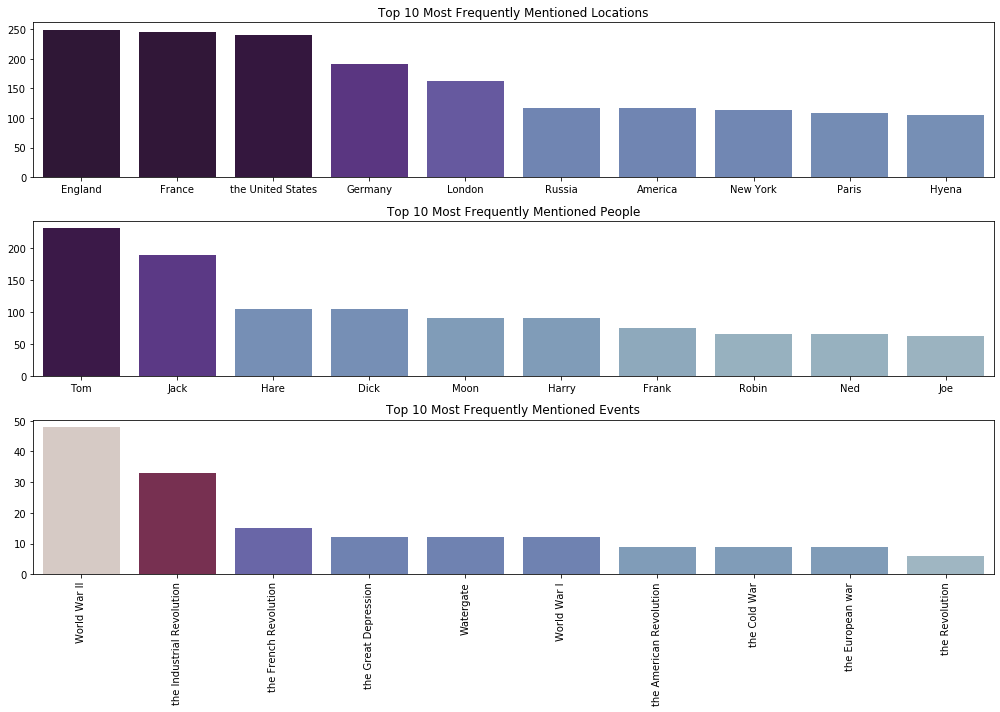

In [22]:
import matplotlib.cm as cm

plt.figure(figsize=(14,10))
plt.subplot(311)
plt.title('Top 10 Most Frequently Mentioned Locations')
sns.barplot(x=top_10_places.index,y=top_10_places.values,palette=cm.twilight(top_10_places.values))
plt.subplot(312)
plt.title('Top 10 Most Frequently Mentioned People')
sns.barplot(x=top_10_person.index,y=top_10_person.values,palette=cm.twilight(top_10_person.values))
plt.subplot(313)
plt.title('Top 10 Most Frequently Mentioned Events')
ax = sns.barplot(x=top_10_event.index,y=top_10_event.values,palette=cm.twilight(top_10_event.values*10))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()

In [23]:
print("Number of the word \"England\" mentioned : ",top_10_places['England'].sum() )
print("Number of the word \"Tom\" mentioned : ",top_10_person['Tom'].sum() )
print("Number of the word \"World War II\" mentioned : ",top_10_event['World War II'].sum() )

Number of the word "England" mentioned :  249
Number of the word "Tom" mentioned :  231
Number of the word "World War II" mentioned :  48


#### 4) Words that are mostly mentioned in all texts

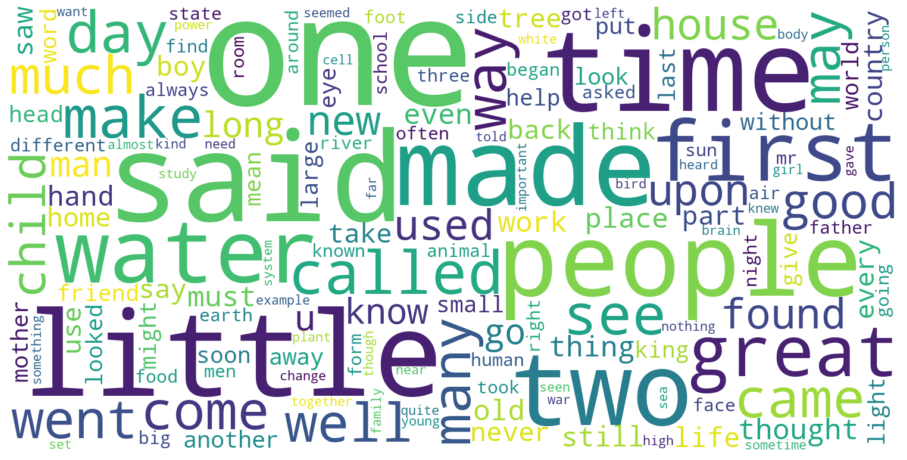

In [24]:
# color function for the wordcloud
plt.subplots(figsize=(16,16))
wc = WordCloud(stopwords=STOPWORDS,
               background_color="white",
               contour_width=2,
               contour_color='blue',
               width=1500, height=750,
               max_words=150, 
               max_font_size=256,
               random_state=42)

wc.generate(' '.join(eda_df['excerpt_preprocessed']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig('C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/wordcloud.jpeg',
            dpi = 600)
plt.show()

#### 5) Correlation between all text properties  

In [25]:
num_cols = ['text_len','text_len_pre','lexicon_count','lexicon_count_pre','avg_word_length','avg_word_length_pre','sentence_count','target']
corr = eda_df[num_cols].corr()
print(corr)

                     text_len  text_len_pre  lexicon_count  lexicon_count_pre  \
text_len             1.000000      0.894186       0.778356           0.835688   
text_len_pre         0.894186      1.000000       0.474619           0.859917   
lexicon_count        0.778356      0.474619       1.000000           0.656835   
lexicon_count_pre    0.835688      0.859917       0.656835           1.000000   
avg_word_length      0.578758      0.803763      -0.057660           0.475936   
avg_word_length_pre  0.515679      0.679090      -0.024463           0.216288   
sentence_count       0.115430      0.081760       0.212245           0.280101   
target              -0.362782     -0.405362      -0.123908          -0.179128   

                     avg_word_length  avg_word_length_pre  sentence_count  \
text_len                    0.578758             0.515679        0.115430   
text_len_pre                0.803763             0.679090        0.081760   
lexicon_count              -0.057660   

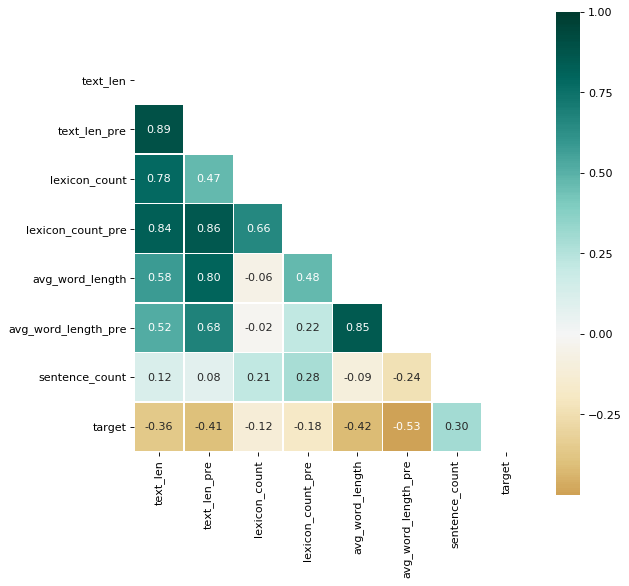

In [27]:
fig = plt.figure(figsize=(8,8),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, cmap='BrBG', mask=mask, robust=True, center=0, square=True, linewidths=.5, annot = True, fmt = ".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.title('Correlation of text properties', fontsize=12)
plt.savefig('C:/Users/haider/Documents/Data Analytics Assignments/Data Analytics Group Project/Text correlation.jpeg',
            dpi = 600,
            bbox_inches='tight')
plt.show()